In [0]:
from pyspark.sql import SparkSession

In [0]:
spark = SparkSession.builder \
   .master("local") \
   .appName("Predicting Fire Dept Calls") \
   .config("spark.executor.memory", "14gb") \
   .getOrCreate()

In [0]:
df = spark.read.format('com.databricks.spark.csv')\
                    .options(header='true', inferschema='true')\
                    .load('dbfs:/FileStore/Fire_Department_Calls_for_Service_big.csv')


In [0]:
import pandas as pd
# pandas_df = pd.read_csv("dbfs:/FileStore/Fire_Department_Calls_for_Service_big.csv")
# pandas_df = pd.read_csv("/dbfs/FileStore/Fire_Department_Calls_for_Service_big.csv")
pandas_df = df.toPandas()

In [0]:
df.show(2)

+-----------+-------+---------------+---------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+----------------------+--------------------+--------------------+-------------+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+-------------+--------------------+----------------------+
Call Number|Unit ID|Incident Number|Call Type| Call Date|Watch Date| Received DtTm| Entry DtTm| Dispatch DtTm| Response DtTm| On Scene DtTm|Transport DtTm|Hospital DtTm|Call Final Disposition| Available DtTm| Address| City|Zipcode of Incident|Battalion|Station Area| Box|Original Priority|Priority|Final Priority|ALS Unit|Call Type Group|Number of Alarms|Unit Type|Unit sequence in call dispatch|Fire Prevention District|Supervisor District|Neighborhooods - Analysis Boundaries| RowID| case_location|Analysis Neighborhoods|
+-----------+-------+---------------+---------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+----------------------+--------------------+--------------------+-------------+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+-------------+--------------------+----------------------+
 210690030| T03| 21030278| Alarms|03/10/2021|03/09/2021|03/10/2021 12:16:...|03/10/2021 12:18:...|03/10/2021 12:19:...|03/10/2021 12:20:...| null| null| null| Fire|03/10/2021 12:28:...|1300 Block of MAR...|San Francisco| 94102| B02| 36|3111| 3| 3| 3| false| Alarm| 1| TRUCK| 3| 2| 6| Tenderloin|210690030-T03|POINT (-122.41697...| 36|
 210391607| E19| 21017645| Alarms|02/08/2021|02/08/2021|02/08/2021 01:00:...|02/08/2021 01:01:...|02/08/2021 01:01:...|02/08/2021 01:03:...|02/08/2021 01:05:...| null| null| Fire|02/08/2021 01:18:...|400 Block of SERR...|San Francisco| 94132| B08| 19|8581| 3| 3| 3| true| Alarm| 1| ENGINE| 1| 8| 7| Lakeshore|210391607-E19|POINT (-122.48045...| 16|
+-----------+-------+---------------+---------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+----------------------+--------------------+--------------------+-------------+-------------------+---------+------------+----+-----------------+--------+--------------+--------+---------------+----------------+---------+------------------------------+------------------------+-------------------+------------------------------------+-------------+--------------------+----------------------+
only showing top 2 rows

In [0]:
df.select('Call Type Group').distinct().show()

+--------------------+
 Call Type Group|
+--------------------+
 Alarm|
 null|
Potentially Life-...|
Non Life-threatening|
 Fire|
+--------------------+

In [0]:
df.groupBy('Call Type Group').count().show()

+--------------------+-------+
 Call Type Group| count|
+--------------------+-------+
 Alarm| 643078|
 null|2812846|
Potentially Life-...|1294174|
Non Life-threatening| 650560|
 Fire| 110333|
+--------------------+-------+

In [0]:
df2 = df.groupBy('Call Type Group').count()

In [0]:
graphDF = df2.toPandas()
graphDF = graphDF.sort_values('count', ascending=False)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

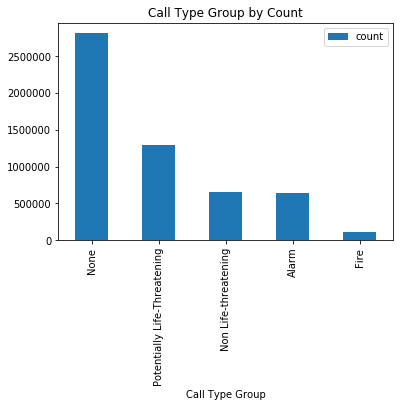

In [0]:
graphDF.plot(x='Call Type Group', y = 'count', kind='bar')
plt.title('Call Type Group by Count')
plt.show()

In [0]:
df.groupBy('Call Type').count().orderBy('count', ascending=False).show(100)

+--------------------+-------+
 Call Type| count|
+--------------------+-------+
 Medical Incident|3603432|
 Structure Fire| 682025|
 Alarms| 600534|
 Traffic Collision| 225304|
 Other| 87659|
Citizen Assist / ...| 82313|
 Outside Fire| 68628|
 Water Rescue| 28383|
 Vehicle Fire| 25548|
Gas Leak (Natural...| 23023|
 Electrical Hazard| 16956|
Elevator / Escala...| 14860|
Odor (Strange / U...| 13005|
Smoke Investigati...| 12568|
 Fuel Spill| 6246|
 HazMat| 4200|
Industrial Accidents| 3080|
 Explosion| 2840|
 Aircraft Emergency| 1511|
 Assist Police| 1448|
Train / Rail Inci...| 1434|
 High Angle Rescue| 1280|
Watercraft in Dis...| 1066|
Extrication / Ent...| 799|
Confined Space / ...| 631|
Mutual Aid / Assi...| 548|
 Oil Spill| 518|
 Marine Fire| 425|
 Suspicious Package| 348|
 Administrative| 286|
 Train / Rail Fire| 84|
Lightning Strike ...| 9|
+--------------------+-------+

In [0]:
from pyspark.sql import functions as F
fireIndicator = df.select(df["Call Type"],F.when(df["Call Type"].like("%Fire%"),1)\
                          .otherwise(0).alias('Fire Indicator'))
fireIndicator.show()

+--------------------+--------------+
 Call Type|Fire Indicator|
+--------------------+--------------+
 Alarms| 0|
 Alarms| 0|
 Alarms| 0|
 Structure Fire| 1|
Citizen Assist / ...| 0|
 Other| 0|
 Alarms| 0|
 Alarms| 0|
 Alarms| 0|
 Alarms| 0|
 Medical Incident| 0|
 Medical Incident| 0|
 Alarms| 0|
 Alarms| 0|
 Medical Incident| 0|
 Outside Fire| 1|
 Outside Fire| 1|
 Alarms| 0|
 Medical Incident| 0|
 Outside Fire| 1|
+--------------------+--------------+
only showing top 20 rows

In [0]:
fireIndicator.groupBy('Fire Indicator').count().show()

+--------------+-------+
Fire Indicator| count|
+--------------+-------+
 1| 776710|
 0|4734281|
+--------------+-------+

In [0]:
df = df.withColumn("fireIndicator", F.when(df["Call Type"].like("%Fire%"),1).otherwise(0))

In [0]:
df.printSchema()

root
-- Call Number: integer (nullable = true)
-- Unit ID: string (nullable = true)
-- Incident Number: integer (nullable = true)
-- Call Type: string (nullable = true)
-- Call Date: string (nullable = true)
-- Watch Date: string (nullable = true)
-- Received DtTm: string (nullable = true)
-- Entry DtTm: string (nullable = true)
-- Dispatch DtTm: string (nullable = true)
-- Response DtTm: string (nullable = true)
-- On Scene DtTm: string (nullable = true)
-- Transport DtTm: string (nullable = true)
-- Hospital DtTm: string (nullable = true)
-- Call Final Disposition: string (nullable = true)
-- Available DtTm: string (nullable = true)
-- Address: string (nullable = true)
-- City: string (nullable = true)
-- Zipcode of Incident: integer (nullable = true)
-- Battalion: string (nullable = true)
-- Station Area: string (nullable = true)
-- Box: string (nullable = true)
-- Original Priority: string (nullable = true)
-- Priority: string (nullable = true)
-- Final Priority: integer (nullable = true)
-- ALS Unit: boolean (nullable = true)
-- Call Type Group: string (nullable = true)
-- Number of Alarms: integer (nullable = true)
-- Unit Type: string (nullable = true)
-- Unit sequence in call dispatch: integer (nullable = true)
-- Fire Prevention District: string (nullable = true)
-- Supervisor District: string (nullable = true)
-- Neighborhooods - Analysis Boundaries: string (nullable = true)
-- RowID: string (nullable = true)
-- case_location: string (nullable = true)
-- Analysis Neighborhoods: integer (nullable = true)
-- fireIndicator: integer (nullable = false)

In [0]:
df.select('Call Type', 'fireIndicator').show(20)

+--------------------+-------------+
 Call Type|fireIndicator|
+--------------------+-------------+
 Alarms| 0|
 Alarms| 0|
 Alarms| 0|
 Structure Fire| 1|
Citizen Assist / ...| 0|
 Other| 0|
 Alarms| 0|
 Alarms| 0|
 Alarms| 0|
 Alarms| 0|
 Medical Incident| 0|
 Medical Incident| 0|
 Alarms| 0|
 Alarms| 0|
 Medical Incident| 0|
 Outside Fire| 1|
 Outside Fire| 1|
 Alarms| 0|
 Medical Incident| 0|
 Outside Fire| 1|
+--------------------+-------------+
only showing top 20 rows

In [0]:
df = df.select('fireIndicator', 
               'Zipcode of Incident',
               'Battalion',
               'Station Area',
               'Box', 
               'Number of Alarms',
               'Unit sequence in call dispatch',
               'Neighborhooods - Analysis Boundaries',
               'Fire Prevention District',
               'Supervisor District')
df.show(5)

+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+
fireIndicator|Zipcode of Incident|Battalion|Station Area| Box|Number of Alarms|Unit sequence in call dispatch|Neighborhooods - Analysis Boundaries|Fire Prevention District|Supervisor District|
+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+
 0| 94102| B02| 36|3111| 1| 3| Tenderloin| 2| 6|
 0| 94132| B08| 19|8581| 1| 1| Lakeshore| 8| 7|
 0| 94158| B03| 04|2264| 1| 1| Mission Bay| 3| 6|
 1| 94102| B02| 03|3114| 1| 1| Tenderloin| 2| 6|
 0| 94123| B04| 16|3233| 1| 1| Marina| 4| 2|
+-------------+-------------------+---------+------------+----+----------------+------------------------------+------------------------------------+------------------------+-------------------+
only showing top 5 rows

In [0]:
print('Total Rows')
df.count()

Total Rows
Out[18]: 5510991

In [0]:
print('Rows without Null values')
df.dropna().count()

Rows without Null values
Out[19]: 5493784

In [0]:
print('Row with Null Values')
df.count()-df.dropna().count()

Row with Null Values
Out[20]: 17207

In [0]:
df = df.dropna()

In [0]:
df.groupBy('fireIndicator').count().orderBy('count', ascending = False).show()

+-------------+-------+
fireIndicator| count|
+-------------+-------+
 0|4718216|
 1| 775568|
+-------------+-------+

In [0]:
from pyspark.ml.feature import StringIndexer

In [0]:
column_names = df.columns[1:]
column_names

Out[24]: ['Zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Number of Alarms',
 'Unit sequence in call dispatch',
 'Neighborhooods - Analysis Boundaries',
 'Fire Prevention District',
 'Supervisor District']

In [0]:
categoricalColumns = column_names
indexers = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"_Index")
    indexers += [stringIndexer]

In [0]:
models = []
for model in indexers:
    indexer_model = model.fit(df)
    models+=[indexer_model]
    
for i in models:
    df = i.transform(df)

In [0]:
df.columns

Out[27]: ['fireIndicator',
 'Zipcode of Incident',
 'Battalion',
 'Station Area',
 'Box',
 'Number of Alarms',
 'Unit sequence in call dispatch',
 'Neighborhooods - Analysis Boundaries',
 'Fire Prevention District',
 'Supervisor District',
 'Zipcode of Incident_Index',
 'Battalion_Index',
 'Station Area_Index',
 'Box_Index',
 'Number of Alarms_Index',
 'Unit sequence in call dispatch_Index',
 'Neighborhooods - Analysis Boundaries_Index',
 'Fire Prevention District_Index',
 'Supervisor District_Index']

In [0]:
df.select('Neighborhooods - Analysis Boundaries', 'Neighborhooods - Analysis Boundaries_Index').show()

+------------------------------------+------------------------------------------+
Neighborhooods - Analysis Boundaries|Neighborhooods - Analysis Boundaries_Index|
+------------------------------------+------------------------------------------+
 Tenderloin| 0.0|
 Lakeshore| 23.0|
 Mission Bay| 28.0|
 Tenderloin| 0.0|
 Marina| 16.0|
 Nob Hill| 7.0|
 Financial Distric...| 3.0|
 Lone Mountain/USF| 27.0|
 Japantown| 32.0|
 Tenderloin| 0.0|
 Nob Hill| 7.0|
 Noe Valley| 29.0|
 Noe Valley| 29.0|
 Tenderloin| 0.0|
 Outer Richmond| 8.0|
 Bayview Hunters P...| 4.0|
 Castro/Upper Market| 10.0|
 Mission| 2.0|
 Nob Hill| 7.0|
 Japantown| 32.0|
+------------------------------------+------------------------------------------+
only showing top 20 rows

In [0]:
df = df.select(
          'fireIndicator',
          'Zipcode of Incident_Index',
          'Battalion_Index',
          'Station Area_Index',
          'Box_Index',
          'Number of Alarms_Index',
          'Unit sequence in call dispatch_Index',
          'Neighborhooods - Analysis Boundaries_Index',
          'Fire Prevention District_Index',
          'Supervisor District_Index')

In [0]:
df.printSchema()

root
-- fireIndicator: integer (nullable = false)
-- Zipcode of Incident_Index: double (nullable = false)
-- Battalion_Index: double (nullable = false)
-- Station Area_Index: double (nullable = false)
-- Box_Index: double (nullable = false)
-- Number of Alarms_Index: double (nullable = false)
-- Unit sequence in call dispatch_Index: double (nullable = false)
-- Neighborhooods - Analysis Boundaries_Index: double (nullable = false)
-- Fire Prevention District_Index: double (nullable = false)
-- Supervisor District_Index: double (nullable = false)

In [0]:
df.show(5)

+-------------+-------------------------+---------------+------------------+---------+----------------------+------------------------------------+------------------------------------------+------------------------------+-------------------------+
fireIndicator|Zipcode of Incident_Index|Battalion_Index|Station Area_Index|Box_Index|Number of Alarms_Index|Unit sequence in call dispatch_Index|Neighborhooods - Analysis Boundaries_Index|Fire Prevention District_Index|Supervisor District_Index|
+-------------+-------------------------+---------------+------------------+---------+----------------------+------------------------------------+------------------------------------------+------------------------------+-------------------------+
 0| 0.0| 1.0| 2.0| 65.0| 0.0| 2.0| 0.0| 0.0| 0.0|
 0| 15.0| 5.0| 22.0| 326.0| 0.0| 0.0| 23.0| 7.0| 7.0|
 0| 25.0| 0.0| 46.0| 939.0| 0.0| 0.0| 28.0| 1.0| 0.0|
 1| 0.0| 1.0| 1.0| 235.0| 0.0| 0.0| 0.0| 0.0| 0.0|
 0| 19.0| 3.0| 17.0| 741.0| 0.0| 0.0| 16.0| 3.0| 6.0|
+-------------+-------------------------+---------------+------------------+---------+----------------------+------------------------------------+------------------------------------------+------------------------------+-------------------------+
only showing top 5 rows

In [0]:
features = df.columns[1:]

In [0]:
from pyspark.ml.feature import VectorAssembler

feature_vectors = VectorAssembler(
        inputCols = features,
        outputCol = "features")

In [0]:
df = feature_vectors.transform(df)

In [0]:
df.columns

Out[35]: ['fireIndicator',
 'Zipcode of Incident_Index',
 'Battalion_Index',
 'Station Area_Index',
 'Box_Index',
 'Number of Alarms_Index',
 'Unit sequence in call dispatch_Index',
 'Neighborhooods - Analysis Boundaries_Index',
 'Fire Prevention District_Index',
 'Supervisor District_Index',
 'features']

In [0]:
df = df.drop( 'Zipcode of Incident_Index',
              'Battalion_Index',
              'Station Area_Index',
              'Box_Index',
              'Number of Alarms_Index',
              'Unit sequence in call dispatch_Index',
              'Neighborhooods - Analysis Boundaries_Index',
              'Fire Prevention District_Index',
              'Supervisor District_Index')

In [0]:
df = df.withColumnRenamed('fireIndicator', 'label')

In [0]:
df.show()

+-----+--------------------+
label| features|
+-----+--------------------+
 0|(9,[1,2,3,5],[1.0...|
 0|[15.0,5.0,22.0,32...|
 0|[25.0,0.0,46.0,93...|
 1|(9,[1,2,3],[1.0,1...|
 0|[19.0,3.0,17.0,74...|
 0|[2.0,3.0,1.0,38.0...|
 0|[7.0,0.0,23.0,190...|
 0|[10.0,8.0,28.0,53...|
 0|[2.0,3.0,15.0,243...|
 0|(9,[1,2,3],[1.0,1...|
 0|[17.0,2.0,11.0,54...|
 0|[11.0,7.0,12.0,16...|
 0|[11.0,7.0,12.0,16...|
 0|(9,[1,2,3,5],[1.0...|
 1|[8.0,9.0,32.0,129...|
 1|[4.0,4.0,33.0,183...|
 0|[11.0,8.0,4.0,95....|
 0|[1.0,1.0,25.0,152...|
 1|[2.0,3.0,1.0,50.0...|
 0|[6.0,8.0,16.0,416...|
+-----+--------------------+
only showing top 20 rows

In [0]:
(trainDF, testDF) = df.randomSplit([0.75, 0.25], seed = 12345)

In [0]:
print(trainDF.count())
print(testDF.count())

4120320
1373464

In [0]:
from pyspark.ml.classification import LogisticRegression
logreg = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
LogisticRegressionModel = logreg.fit(trainDF)

In [0]:
df_predicted = LogisticRegressionModel.transform(testDF)

In [0]:
df_predicted.printSchema()

root
-- label: integer (nullable = false)
-- features: vector (nullable = true)
-- rawPrediction: vector (nullable = true)
-- probability: vector (nullable = true)
-- prediction: double (nullable = false)

In [0]:
df_predicted.show(5)

+-----+--------------------+--------------------+--------------------+----------+
label| features| rawPrediction| probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
 0|(9,[0,1,2,3],[1.0...|[2.70005968089914...|[0.93703016548449...| 0.0|
 0|(9,[0,1,2,3],[1.0...|[2.70005968089914...|[0.93703016548449...| 0.0|
 0|(9,[0,1,2,3],[1.0...|[2.70005968089914...|[0.93703016548449...| 0.0|
 0|(9,[0,1,2,3],[1.0...|[2.70005968089914...|[0.93703016548449...| 0.0|
 0|(9,[0,1,2,3],[1.0...|[2.70005968089914...|[0.93703016548449...| 0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

In [0]:
df_predicted.crosstab('label', 'prediction').show()

+----------------+-------+-----+
label_prediction| 0.0| 1.0|
+----------------+-------+-----+
 1| 139417|54250|
 0|1169786|10011|
+----------------+-------+-----+

In [0]:
from sklearn import metrics

In [0]:
actual = df_predicted.select('label').toPandas()

In [0]:
predicted = df_predicted.select('prediction').toPandas()

In [0]:
metrics.accuracy_score(actual, predicted)

Out[49]: 0.8912035553898755

In [0]:
df_predicted.groupBy('label').count().show()

+-----+-------+
label| count|
+-----+-------+
 1| 193667|
 0|1179797|
+-----+-------+

In [0]:
df_predicted.describe('label').show()

+-------+-------------------+
summary| label|
+-------+-------------------+
 count| 1373464|
 mean|0.14100624406609857|
 stddev| 0.3480281186755677|
 min| 0|
 max| 1|
+-------+-------------------+